# Compare methods using HBEC data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functools
import numpy as np
from statsmodels.stats.multitest import fdrcorrection
import scipy.stats as stats

In [2]:
data_path = '/data_volume/memento/method_comparison/hbec/'

### Compute the concordance curve

In [3]:
def safe_fdr(x):
    fdr = np.ones(x.shape[0])
    _, fdr[np.isfinite(x)] = fdrcorrection(x[np.isfinite(x)])
    return fdr

In [4]:
def concordance_curve(ref1, ref2, ref3, ref4, x, k=300):
    overlap = []
    for i in range(1, k+1):
        
        a = len(set(x[:i]) & set(ref1[:i]))
        b = len(set(x[:i]) & set(ref2[:i]))
        c = len(set(x[:i]) & set(ref3[:i]))
        d = len(set(x[:i]) & set(ref4[:i]))
        overlap.append((a+b+c+d)/4)
        
    return np.arange(1, k+1), np.array(overlap)

In [5]:
def concordance_auc(x, y, k=100):
    count = 0
    for i in range(1, k+1):
        
        count += len(set(x[:i]) & set(y[:i]))
    return count / (k*(k+1)/2)

### Read results - alpha vs beta

In [86]:
all_results = []
for ct in ['BC', 'C', 'B']:

    for tp in ['3', '6', '9', '24', '48']:
        
        stim = 'alpha'
        alpha_name_paths = [
            ('edgeR','hbec.pseudobulk.edger_lrt.{}.{}.{}.csv'.format(ct, tp, stim), ['logFC','PValue', 'FDR']),
            ('DESeq2','hbec.pseudobulk.deseq2_wald.{}.{}.{}.csv'.format(ct, tp, stim), ['log2FoldChange','pvalue', 'padj']),
            ('t-test','hbec.sc.ttest.{}.{}.{}.csv'.format(ct, tp, stim), ['logFC','PValue', 'FDR']),
            ('MWU', 'hbec.sc.mwu.{}.{}.{}.csv'.format(ct, tp, stim), ['logFC', 'PValue', 'FDR']),
            ('MAST', 'hbec.sc.MAST.{}.{}.{}.csv'.format(ct, tp, stim), ['coef','Pr(>Chisq)', 'fdr']),
            ('memento', 'hbec.sc.weighted_mean_glm.{}.{}.{}.csv'.format(ct, tp, stim), ['logFC','PValue', 'FDR']),

        ]
        stim = 'beta'
        beta_name_paths = [
            ('edgeR','hbec.pseudobulk.edger_lrt.{}.{}.{}.csv'.format(ct, tp, stim), ['logFC','PValue', 'FDR']),
            ('DESeq2','hbec.pseudobulk.deseq2_wald.{}.{}.{}.csv'.format(ct, tp, stim), ['log2FoldChange','pvalue', 'padj']),
            ('t-test','hbec.sc.ttest.{}.{}.{}.csv'.format(ct, tp, stim), ['logFC','PValue', 'FDR']),
            ('MWU', 'hbec.sc.mwu.{}.{}.{}.csv'.format(ct, tp, stim), ['logFC', 'PValue', 'FDR']),
            ('MAST', 'hbec.sc.MAST.{}.{}.{}.csv'.format(ct, tp, stim), ['coef','Pr(>Chisq)', 'fdr']),
            ('memento', 'hbec.sc.weighted_mean_glm.{}.{}.{}.csv'.format(ct, tp, stim), ['logFC','PValue', 'FDR']),

        ]
        alpha_results = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in alpha_name_paths]
        beta_results = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in beta_name_paths]
        # alpha_results[1]['FDR'] = safe_fdr(alpha_results[1]['PValue'])
        # beta_results[1]['FDR'] = safe_fdr(beta_results[1]['PValue'])
        
        combined_result = alpha_results + beta_results
        gene_lists = [set(res.index) for res in combined_result]
        genes = list(functools.reduce(lambda x,y: x & y, gene_lists))
        
        alpha_results = [res.loc[genes].sort_values('FDR') for res in alpha_results]
        beta_results = [res.loc[genes].sort_values('FDR') for res in beta_results]
        
        scores = [
            (
                alpha_name_paths[idx][0].replace('_', '\n'), 
                ct, 
                tp,
                concordance_auc(alpha_res.index, beta_res.index),
            ) for idx, (alpha_res, beta_res) in enumerate(zip(alpha_results, beta_results))]
        all_results+=scores


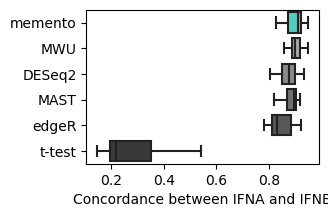

In [91]:
df = pd.DataFrame(
    all_results, 
    columns=['name', 'ct', 'tp', 'auc'])

plt.figure(figsize=(3,2))
pal = [(64/255,224/255,208/255)]+sns.color_palette("Greys", 10)[4:]
sns.boxplot(
    y='name',
    x='auc', 
    data=df, 
    order=[
        'memento',
        'MWU',
        'DESeq2',
        'MAST',
        'edgeR',
        't-test',
    ],
    palette=pal)
    
plt.xlabel('Concordance between IFNA and IFNB')
plt.ylabel('')
plt.savefig('hbec_alpha_beta_comparison.pdf', bbox_inches='tight')

### Combined cell types

In [112]:
all_results = []

for tp in ['3', '6', '9', '24', '48']:

    stim = 'alpha'
    alpha_name_paths = [
        ('edgeR','hbec.pseudobulk.edger_lrt.{}.{}.csv'.format( tp, stim), ['logFC','PValue', 'FDR']),
        ('DESeq2','hbec.pseudobulk.deseq2_wald.{}.{}.csv'.format( tp, stim), ['log2FoldChange','pvalue', 'padj']),
        ('t-test','hbec.sc.ttest.{}.{}.csv'.format(tp, stim), ['logFC','PValue', 'FDR']),
        ('MWU', 'hbec.sc.mwu.{}.{}.csv'.format( tp, stim), ['logFC', 'PValue', 'FDR']),
        # ('MAST', 'hbec.sc.MAST.{}.{}.{}.csv'.format(ct, tp, stim), ['coef','Pr(>Chisq)', 'fdr']),
        ('memento', 'hbec.sc.weighted_mean_glm.{}.{}.csv'.format(tp, stim), ['logFC','PValue', 'FDR']),

    ]
    stim = 'beta'
    beta_name_paths = [
        ('edgeR','hbec.pseudobulk.edger_lrt.{}.{}.csv'.format( tp, stim), ['logFC','PValue', 'FDR']),
        ('DESeq2','hbec.pseudobulk.deseq2_wald.{}.{}.csv'.format( tp, stim), ['log2FoldChange','pvalue', 'padj']),
        ('t-test','hbec.sc.ttest.{}.{}.csv'.format(tp, stim), ['logFC','PValue', 'FDR']),
        ('MWU', 'hbec.sc.mwu.{}.{}.csv'.format(tp, stim), ['logFC', 'PValue', 'FDR']),
        # ('MAST', 'hbec.sc.MAST.{}.{}.{}.csv'.format(ct, tp, stim), ['coef','Pr(>Chisq)', 'fdr']),
        ('memento', 'hbec.sc.weighted_mean_glm.{}.{}.csv'.format(tp, stim), ['logFC','PValue', 'FDR']),

    ]
    alpha_results = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in alpha_name_paths]
    beta_results = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in beta_name_paths]
    # alpha_results[1]['FDR'] = safe_fdr(alpha_results[1]['PValue'])
    # beta_results[1]['FDR'] = safe_fdr(beta_results[1]['PValue'])

    combined_result = alpha_results + beta_results
    gene_lists = [set(res.index) for res in combined_result]
    genes = list(functools.reduce(lambda x,y: x & y, gene_lists))

    alpha_results = [res.loc[genes].sort_values('FDR') for res in alpha_results]
    beta_results = [res.loc[genes].sort_values('FDR') for res in beta_results]

    scores = [
        (
            alpha_name_paths[idx][0].replace('_', '\n'), 
            tp,
            concordance_auc(alpha_res.index, beta_res.index),
        ) for idx, (alpha_res, beta_res) in enumerate(zip(alpha_results, beta_results))]
    all_results+=scores


/tmp/ipykernel_16192/3200823322.py:7: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
/tmp/ipykernel_16192/3200823322.py:7: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.stripplot(


Text(0, 0.5, '')

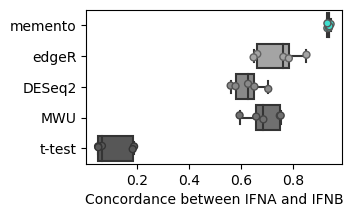

In [120]:
df = pd.DataFrame(
    all_results, 
    columns=['name', 'tp', 'auc'])

plt.figure(figsize=(3.3,2))
pal = [(64/255,224/255,208/255)]+sns.color_palette("Greys", 10)[4:]
sns.stripplot(
    y='name',
    x='auc', 
    data=df, 
    order=[
        'memento',
        'edgeR',
        'DESeq2',
        # 'MAST',
        'MWU',
        't-test',],
    palette=pal,
    linewidth=1)
sns.boxplot(
    y='name',
    x='auc', 
    data=df, 
    order=[
        'memento',
        'edgeR',
        'DESeq2',
        # 'MAST',
        'MWU',
        't-test',],
    palette=pal)
plt.xlabel('Concordance between IFNA and IFNB')
plt.ylabel('')
# plt.savefig('hbec_alpha_beta_comparison.pdf', bbox_inches='tight')

Text(0, 0.5, 'Concordance between alpha vs beta')

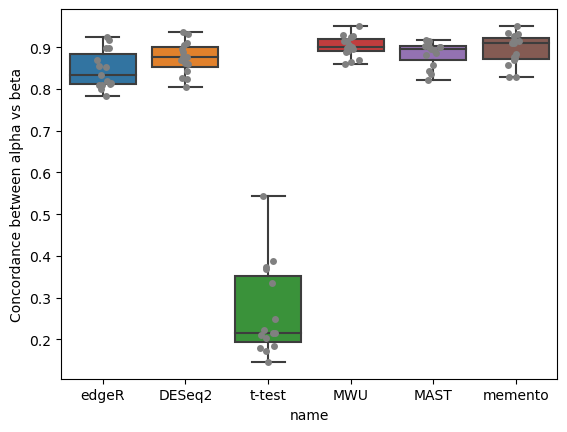

In [90]:
sns.boxplot(x='name', y='auc', data=df)
sns.stripplot(x='name', y='auc', data=df, color='grey')
plt.ylabel('Concordance between alpha vs beta')

Text(0, 0.5, 'Concordance between alpha vs beta')

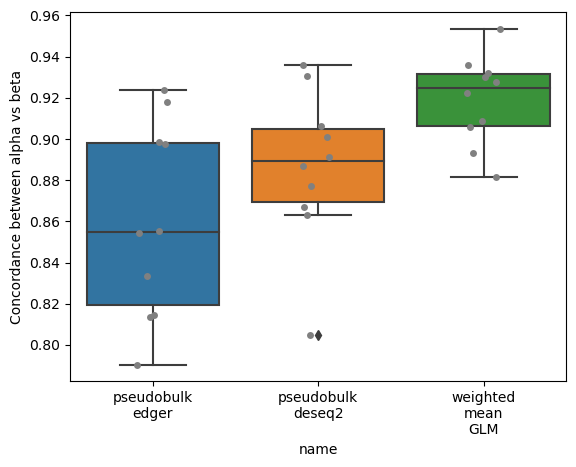

In [171]:
sns.boxplot(x='name', y='auc', data=df.query('name != "ttest"'))
sns.stripplot(x='name', y='auc', data=df.query('name != "ttest"'), color='grey')
plt.ylabel('Concordance between alpha vs beta')

### Play around with single trial

In [152]:
all_results = []
for ct in ['BC', 'B']:#['BC', 'B', 'C']:

    for tp in ['3', '6', '9', '24', '48']:
        
        stim = 'alpha'
        alpha_name_paths = [
            ('pseudobulk_edger','hbec.pseudobulk.edger_lrt.{}.{}.{}.csv'.format(ct, tp, stim), ['logFC','PValue', 'FDR']),
            ('pseudobulk_deseq2','hbec.pseudobulk.deseq2_wald.{}.{}.{}.csv'.format(ct, tp, stim), ['log2FoldChange','pvalue', 'padj']),
            ('ttest','hbec.sc.ttest.{}.{}.{}.csv'.format(ct, tp, stim), ['logFC','PValue', 'FDR']),
            ('weighted_mean_GLM', 'hbec.sc.weighted_mean_glm.{}.{}.{}.csv'.format(ct, tp, stim), ['logFC','PValue', 'FDR']),

        ]
        stim = 'beta'
        beta_name_paths = [
            ('pseudobulk_edger','hbec.pseudobulk.edger_lrt.{}.{}.{}.csv'.format(ct, tp, stim), ['logFC','PValue', 'FDR']),
            ('pseudobulk_deseq2','hbec.pseudobulk.deseq2_wald.{}.{}.{}.csv'.format(ct, tp, stim), ['log2FoldChange','pvalue', 'padj']),
            ('ttest','hbec.sc.ttest.{}.{}.{}.csv'.format(ct, tp, stim), ['logFC','PValue', 'FDR']),
            ('weighted_mean_GLM', 'hbec.sc.weighted_mean_glm.{}.{}.{}.csv'.format(ct, tp, stim), ['logFC','PValue', 'FDR']),

        ]
        alpha_results = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in alpha_name_paths]
        beta_results = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in beta_name_paths]
        # alpha_results[1]['FDR'] = safe_fdr(alpha_results[1]['PValue'])
        # beta_results[1]['FDR'] = safe_fdr(beta_results[1]['PValue'])
        
        combined_result = alpha_results + beta_results
        gene_lists = [set(res.index) for res in combined_result]
        genes = list(functools.reduce(lambda x,y: x & y, gene_lists))
        
        alpha_results = [res.loc[genes].sort_values('FDR') for res in alpha_results]
        beta_results = [res.loc[genes].sort_values('FDR') for res in beta_results]
        
        scores = [
            (
                alpha_name_paths[idx][0],#.replace('_', '\n'), 
                ct, 
                tp,
                concordance_auc(alpha_res.index, beta_res.index),
            ) for idx, (alpha_res, beta_res) in enumerate(zip(alpha_results, beta_results))]
        all_results+=scores
        
        break
    break
df = pd.DataFrame(
    all_results, 
    columns=['name', 'ct', 'tp', 'auc'])

In [153]:
df

,name,ct,tp,auc
0,pseudobulk_edger,BC,3,0.691765
1,pseudobulk_deseq2,BC,3,0.858824
2,ttest,BC,3,0.128627
3,weighted_mean_GLM,BC,3,0.925490


In [109]:
name_paths = [
    ('bulk_edger_lrt','T4_vs_cM.bulk.edger_lrt.csv', ['logFC','PValue', 'FDR']), 
    ('bulk_edger_qlft','T4_vs_cM.bulk.edger_qlft.csv', ['logFC','PValue', 'FDR']), 
    ('bulk_deseq2_wald', 'T4_vs_cM.bulk.deseq2_wald.csv', ['log2FoldChange','pvalue', 'padj']),
    ('bulk_deseq2_lrt', 'T4_vs_cM.bulk.deseq2_lrt.csv', ['log2FoldChange','pvalue', 'padj']),
    ('pseudobulk_edger','T4_vs_cM.pseudobulk.edger_lrt.csv', ['logFC','PValue', 'FDR']),
    ('pseudobulk_deseq2','T4_vs_cM.pseudobulk.deseq2_wald.csv', ['log2FoldChange','pvalue', 'padj']),
    ('ttest','T4_vs_cM.sc.ttest.csv', ['logFC','PValue', 'FDR']),
    ('sum_GLM', 'T4_vs_cM.sc.sum_glm.csv', ['logFC','PValue', 'FDR']),
    ('weighted_mean_GLM', 'T4_vs_cM.sc.weighted_mean_glm.csv', ['logFC','PValue', 'FDR']),
    ('memento', 'T4_vs_cM.sc.memento.csv', ['de_coef','de_pval', 'de_fdr']),
    ('weighted_mean_WLS', 'T4_vs_cM.sc.weighted_mean_wls.csv', ['logFC','PValue', 'FDR'])
    
]
results = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in name_paths]
gene_lists = [set(res.index) for res in results]
genes = list(functools.reduce(lambda x,y: x & y, gene_lists))
results = [res.loc[genes].sort_values('FDR') for res in results]

curves = [
    concordance_curve(
        results[0].index, 
        results[1].index, 
        results[2].index,
        results[3].index,
        res.index) for res in results[4:]]

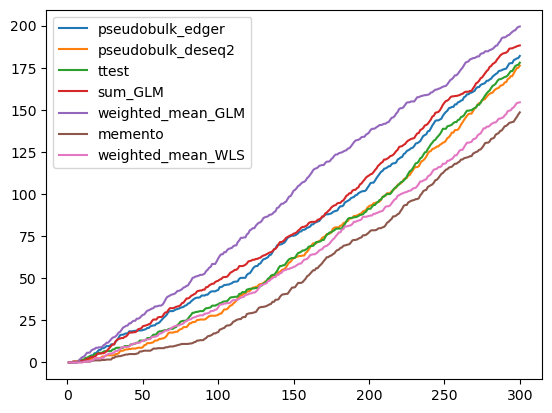

In [110]:
for idx, (x,y) in enumerate(curves):
    plt.plot(x,y, label=name_paths[idx+4][0])
plt.legend()

<AxesSubplot: >

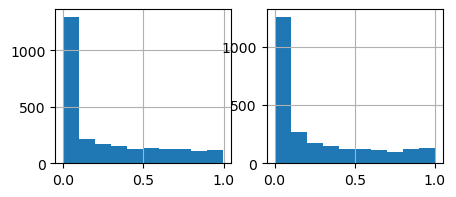

In [111]:
plt.figure(figsize=(5,2))

plt.subplot(1, 2, 1)
results[4]['PValue'].hist()

plt.subplot(1, 2, 2)
results[-3]['PValue'].hist()

### Read results with repeated trials

In [ ]:
all_results = []
for numcells in [50, 100, 150, 200]:
    for trial in range(50):        
        name_paths = [
            ('bulk_edger_lrt','T4_vs_cM.bulk.edger_lrt.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']), 
            ('bulk_edger_qlft','T4_vs_cM.bulk.edger_qlft.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
            ('bulk_deseq2_wald', 'T4_vs_cM.bulk.deseq2_wald.{}.{}.csv'.format(numcells, trial), ['log2FoldChange','pvalue', 'padj']),
            ('bulk_deseq2_lrt', 'T4_vs_cM.bulk.deseq2_lrt.{}.{}.csv'.format(numcells, trial), ['log2FoldChange','pvalue', 'padj']),
            ('pseudobulk_edger','T4_vs_cM.pseudobulk.edger_lrt.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
            ('pseudobulk_deseq2','T4_vs_cM.pseudobulk.deseq2_wald.{}.{}.csv'.format(numcells, trial), ['log2FoldChange','pvalue', 'padj']),
            ('ttest','T4_vs_cM.sc.ttest.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
            ('weighted_mean_GLM', 'T4_vs_cM.sc.weighted_mean_glm.{}.{}.csv'.format(numcells, trial), ['logFC','PValue', 'FDR']),
        ]
        results = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in name_paths]
        gene_lists = [set(res.index) for res in results]
        genes = list(functools.reduce(lambda x,y: x & y, gene_lists))
        results = [res.loc[genes].sort_values('FDR') for res in results]

        scores = [
            (name_paths[idx+4][0].replace('_', '\n'), numcells, concordance_auc(
                results[0].index, 
                results[1].index, 
                results[2].index,
                results[3].index,
                res.index)) for idx, res in enumerate(results[4:])]
        all_results+=scores
        
        curves = [
            concordance_curve(
                results[0].index, 
                results[1].index, 
                results[2].index,
                results[3].index,
                res.index) for res in results[4:]]


KeyboardInterrupt



In [225]:
# plt.figure(figsize=(3,3))
# for idx, (x,y) in enumerate(curves):
#     plt.plot(x,y, label=name_paths[idx+4][0])
# plt.legend()
# plt.xlabel('Number of top genes')
# plt.ylabel('Overlap with bulk RNA-seq')

In [226]:
df = pd.DataFrame(all_results, columns=['name', 'numcells', 'auc'])

<AxesSubplot: xlabel='name', ylabel='auc'>

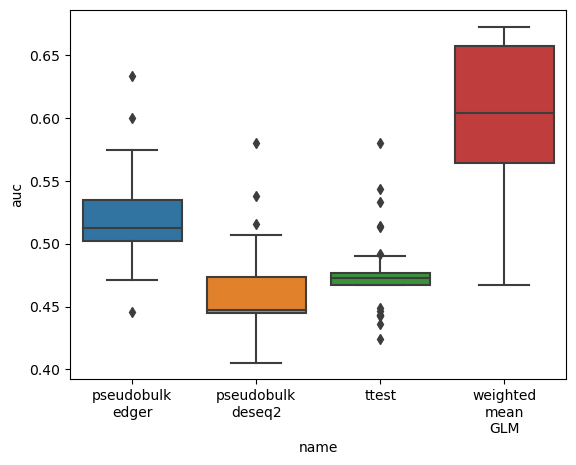

In [227]:
sns.boxplot(x='name', y='auc', data=df.query('numcells==50'), hue_order=['weighted\nmean\nGLM','pseudobulk\nedger','ttest','pseudobulk\ndeseq2'])


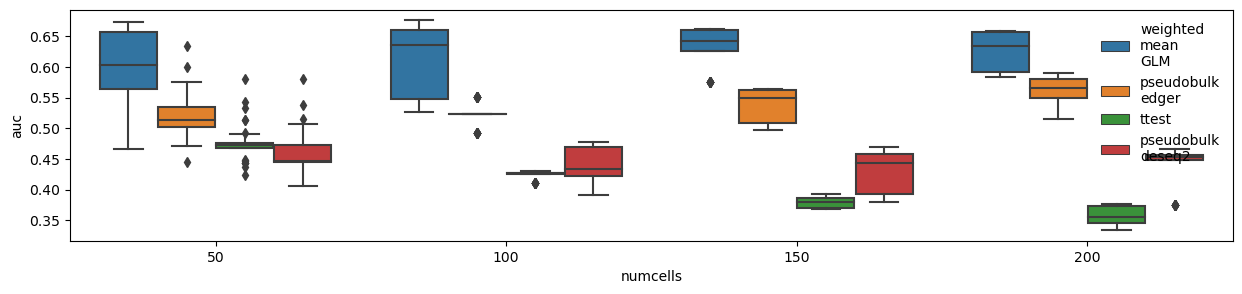

In [229]:
plt.figure(figsize=(15,3))
sns.boxplot(x='numcells', y='auc', hue='name', data=df, hue_order=['weighted\nmean\nGLM','pseudobulk\nedger','ttest','pseudobulk\ndeseq2'])
# sns.stripplot(x='name', y='auc', data=df, order=['weighted\nmean\nGLM','pseudobulk\nedger','ttest','pseudobulk\ndeseq2'], color='grey')

# sns.stripplot(x='name', y='auc', data=df)
plt.legend(frameon=False)

In [139]:
name_paths = [
    ('bulk_edger_lrt','T4_vs_cM.bulk.edger_lrt.csv', ['logFC','PValue', 'FDR']), 
    ('bulk_edger_qlft','T4_vs_cM.bulk.edger_qlft.csv', ['logFC','PValue', 'FDR']),
    ('bulk_deseq2_wald', 'T4_vs_cM.bulk.deseq2_wald.csv', ['log2FoldChange','pvalue', 'padj']),
    ('bulk_deseq2_lrt', 'T4_vs_cM.bulk.deseq2_lrt.csv', ['log2FoldChange','pvalue', 'padj']),
    ('pseudobulk_edger','T4_vs_cM.pseudobulk.edger.csv', ['logFC','PValue', 'FDR']),
    ('pseudobulk_deseq2','T4_vs_cM.pseudobulk.deseq2.csv', ['log2FoldChange','pvalue', 'padj']),
    ('ttest','T4_vs_cM.sc.ttest.csv', ['logFC','PValue', 'FDR']),
    ('weighted_mean_GLM', 'T4_vs_cM.sc.weighted_mean_glm.csv', ['logFC','PValue', 'FDR']),
]
results = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in name_paths]
gene_lists = [set(res.index) for res in results]
genes = list(functools.reduce(lambda x,y: x & y, gene_lists))
results = [res.loc[genes].sort_values('FDR') for res in results]

curves = [
    concordance_curve(
        results[0].index, 
        results[1].index, 
        results[2].index,
        results[3].index,
        res.index) for res in results[4:]]

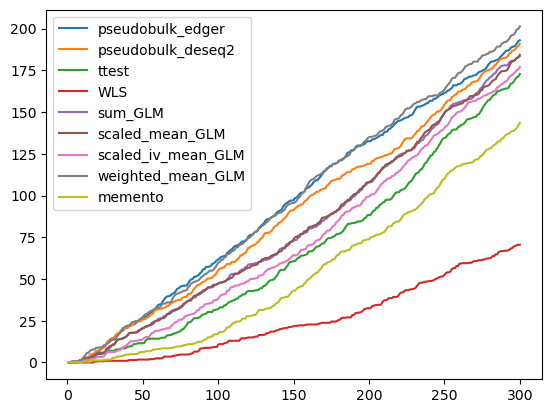

In [142]:
for idx, (x,y) in enumerate(curves):
    plt.plot(x,y, label=name_paths[idx+4][0])
plt.legend()